In [1]:
# Reference: https://debuggercafe.com/instance-segmentation-with-pytorch-and-mask-r-cnn/
import cv2
import numpy as np
import random
import torch
import torchvision
import cv2
import argparse
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import transforms as transforms

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

coco_names = COCO_INSTANCE_CATEGORY_NAMES
# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

def get_outputs(image, model, threshold):
    with torch.no_grad():
        # forward pass of the image through the modle
        outputs = model(image)
    
    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    # get the masks
    masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # discard masks for objects which are below threshold
    masks = masks[:thresholded_preds_count]
    # get the bounding boxes, in (x1, y1), (x2, y2) format
    boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
    # discard bounding boxes below threshold value
    boxes = boxes[:thresholded_preds_count]
    # get the classes labels
    labels = [coco_names[i] for i in outputs[0]['labels']]
    return masks, boxes, labels

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1 
    beta = 0.6 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    for i in range(len(masks)):
        red_map = np.zeros_like(masks[i]).astype(np.uint8)
        green_map = np.zeros_like(masks[i]).astype(np.uint8)
        blue_map = np.zeros_like(masks[i]).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = color
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        #convert the original PIL image into NumPy format
        image = np.array(image)
        # convert from RGN to OpenCV BGR format
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # apply mask on the image
        cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
#         # draw the bounding boxes around the objects
#         cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color, 
#                       thickness=2)
#         # put the label text above the objects
#         cv2.putText(image , labels[i], (boxes[i][0][0], boxes[i][0][1]-10), 
#                     cv2.FONT_HERSHEY_SIMPLEX, 1, color, 
#                     thickness=2, lineType=cv2.LINE_AA)
    
    return image

In [2]:
# initialize the model
model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(pretrained=True, progress=True, 
                                                           num_classes=91)
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the modle on to the computation device and set to eval mode
model.to(device).eval()

# transform to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

/home/zippingsugar/Programs/visual-affordance-pushing/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zippingsugar/Programs/visual-affordance-pushing/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


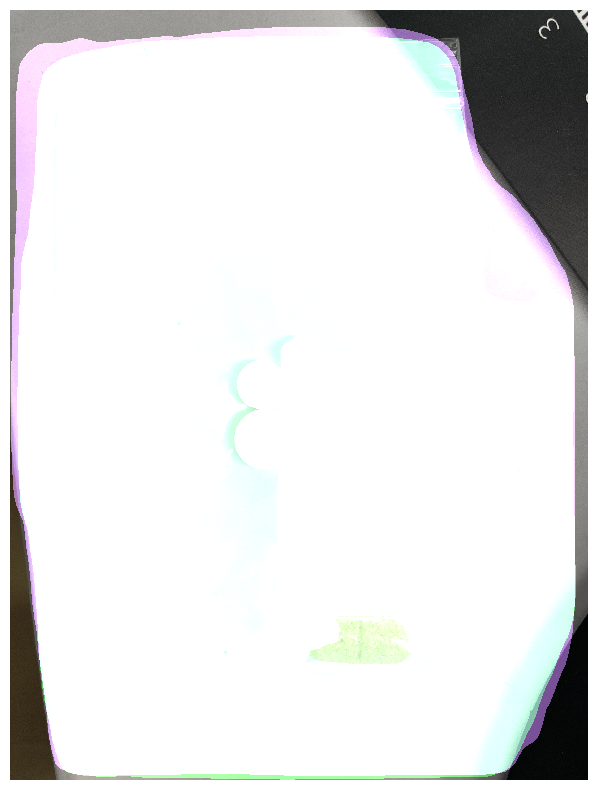

In [3]:
threshold = 0.2
# image = cv2.imread('./images/000012.0.color.png')
image = cv2.imread('./images/pills_1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# keep a copy of the original image for OpenCV functions and applying masks
orig_image = image.copy()
# transform the image
image = transform(image)
# add a batch dimension
image = image.unsqueeze(0).to(device)
masks, boxes, labels = get_outputs(image, model, threshold)
result = draw_segmentation_map(orig_image, masks, boxes, labels)
# visualize the image
plt.figure(figsize=(10,10))
plt.imshow(result)
plt.axis('off')
plt.show()

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        # Find the contours of the mask
        contours, hierarchy = cv2.findContours(m.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # Draw the contours in white color
        cv2.drawContours(img, contours, -1, (0, 0, 1), 6)
        ax.imshow(np.dstack((img, m*0.6)))
        
def cuts_out(img, anns, save_dir):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    for i, ann in enumerate(sorted_anns):
#     for ann in sorted_anns:
        m = ann['segmentation']

        # Apply the mask to the image
        img_masked = cv2.bitwise_and(img, img, mask = m.astype(np.uint8))

        # Find the bounding box of the mask
        x, y, w, h = cv2.boundingRect(m.astype(np.uint8))

        # Crop the image to the bounding box
        img_cropped = img_masked[y:y + h, x:x + w]

        # Save the cropped image in the save directory
        if os.path.exists(save_dir) is False:
            os.mkdir(save_dir)
        cv2.imwrite(os.path.join(save_dir, 'cuts_out_{}.jpg'.format(i)), img_cropped)
    print("Done")

In [22]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/home/zippingsugar/Programs/segment-anything/checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

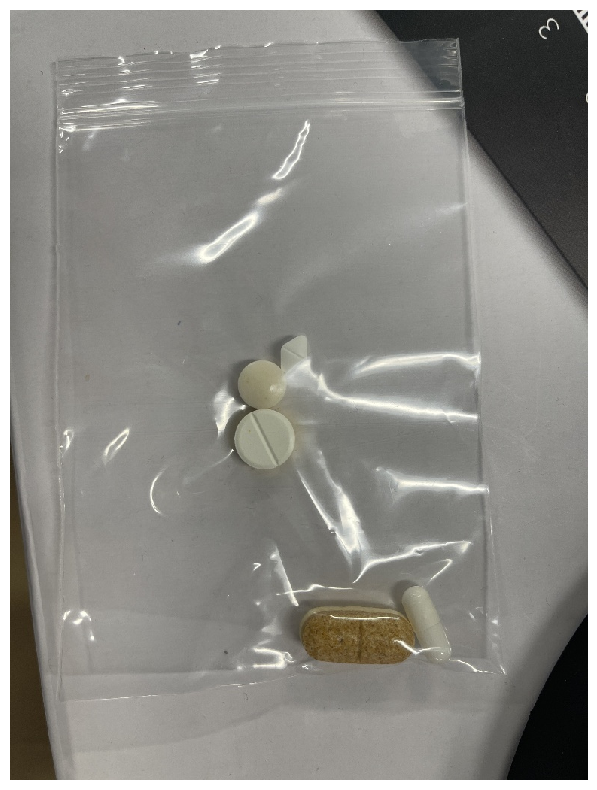

In [42]:
import os
img_dir = './images/'
img_name = "pills_1"
image = cv2.imread(os.path.join(img_dir,img_name+'.jpg'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [57]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    points_per_batch= 64,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.96,
    min_mask_region_area=50,  # Requires open-cv to run post-processing
)

3.9641010761260986


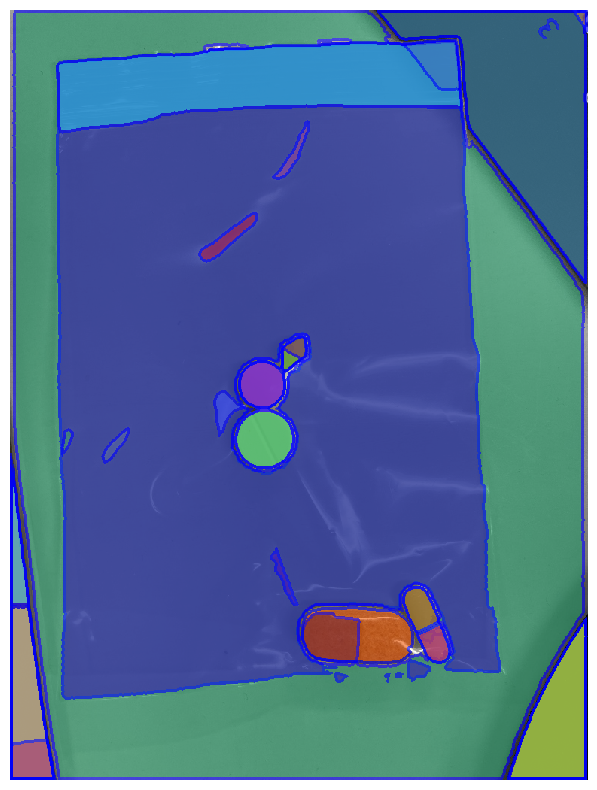

In [58]:
import time
st = time.time()
masks = mask_generator.generate(image)
et = time.time()
print(et-st)
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [60]:
cuts_out(image, masks2, os.path.join(img_dir,img_name))

Done
